In [44]:
# Elimino todas las variables excepto loan_data_knn y loan_data2
rm(list = setdiff(ls(), c("loan_data_knn", "loan_data2")))

In [45]:
# importacion de librerias
library(readr)
library(caret)
library(ggplot2)
library(dplyr)
library(vcd)
library(reshape2)
library(ltm)
library(gmodels)
library(pROC)
library(kknn)
library(rsample)
library(doParallel)

In [46]:
loan_data_knn <- read_csv("Anonymize_Loan_Default_data_ML2.csv")
loan_data_knn <- as.data.frame(loan_data_knn)

Rows: 38345 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): term, last_pymnt_d, last_credit_pull_d
dbl (18): loan_amnt, funded_amnt, funded_amnt_inv, int_rate, installment, an...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Eliminacion de algunas columnas numericas, bajo criterio correlacion biserial

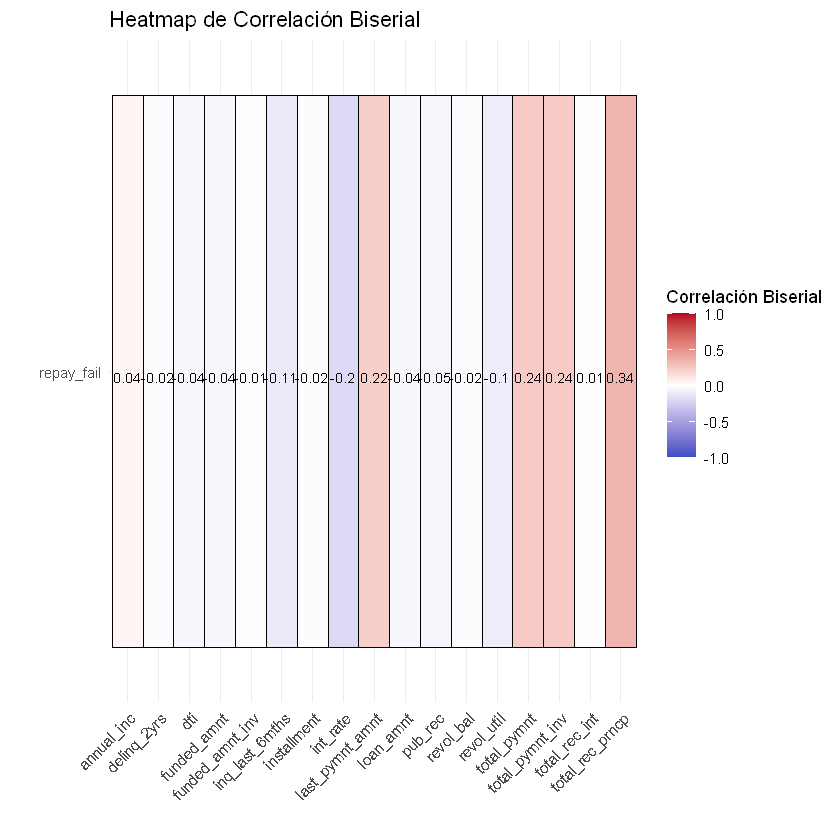

In [47]:
# Selecciono solo las columnas numéricas
numeric_vars <- sapply(loan_data_knn, is.numeric)
datos_numericos <- loan_data_knn[, numeric_vars]

# Añado 'repay_fail' a los datos numéricos
datos_numericos$repay_fail <- loan_data_knn$repay_fail

# Función para calcular la correlación biserial
cor_biserial <- function(x, y) {
  biserial.cor(x, y)
}

# Calculo la correlación biserial entre cada variable numérica y 'repay_fail'
correlaciones <- sapply(datos_numericos[, -ncol(datos_numericos)], cor_biserial, y = datos_numericos$repay_fail)

# Convierto las correlaciones a un data frame para ggplot
correlaciones_df <- data.frame(Variable = names(correlaciones), Correlacion = correlaciones)

# Ajusto tamaño de etiquetas para mejorar la visualización
correlaciones_df$Correlacion <- round(correlaciones_df$Correlacion, 2)

# Creo el heatmap con etiquetas mejoradas
ggplot(correlaciones_df, aes(x = Variable, y = "repay_fail", fill = Correlacion)) +
  geom_tile(color = "black") +
  geom_text(aes(label = Correlacion), vjust = 1, color = "black", size = 3) +
  scale_fill_gradient2(low = "#3B4CC0", mid = "#FFFFFF", high = "#B40426", 
                       midpoint = 0, limit = c(-1, 1), space = "Lab", 
                       name = "Correlación Biserial") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "", y = "", title = "Heatmap de Correlación Biserial")


In [48]:
#por ende procedo a eliminar las variables que tienen baja
# correlación con la variable objetivo
#osea elimino funded_amnt_inv, installment, revol_bal, total_rec_int
# delinq_2yrs, funded_amnt, pub_rec, inq_last_6mths, loan_amnt, revol_util
loan_data_knn <- loan_data_knn %>%
  dplyr::select(-funded_amnt_inv, -installment, -revol_bal,
                -total_rec_int, -delinq_2yrs, -funded_amnt, -pub_rec,
                -inq_last_6mths, -loan_amnt, -revol_util)

In [49]:
head(loan_data_knn)

,term,int_rate,annual_inc,dti,total_pymnt,total_pymnt_inv,total_rec_prncp,last_pymnt_amnt,repay_fail,last_pymnt_d,last_credit_pull_d
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,36 months,13.98,20004,19.86,3075.292,3075.29,2500.00,90.85,0,2011-2013,2014-2016
2,36 months,15.95,59000,19.57,2948.760,2948.76,1909.02,175.67,1,2011-2013,2011-2013
3,36 months,9.91,53796,10.80,8082.392,8082.39,7000.00,1550.27,0,2014-2016,2014-2016
4,36 months,5.42,30000,3.60,2161.663,2161.66,2000.00,53.12,0,2014-2016,2014-2016
5,36 months,10.25,675048,1.55,4206.031,4206.03,3600.00,146.75,0,2011-2013,2014-2016
6,36 months,6.03,77736,6.07,8724.972,8724.97,8000.00,1423.66,0,2014-2016,2014-2016


Modelo k-NN de clasificacion

In [50]:
# Selecciono las columnas categóricas específicas
col_cate <- c("term", "last_pymnt_d", "last_credit_pull_d")

# Calculo los valores por clase para las columnas especificadas en loan_data_knn
valores_por_clase <- lapply(loan_data_knn[col_cate], table)

# Muestro los valores por clase
valores_por_clase

$term

36 months 60 months 
    28478      9867 

$last_pymnt_d

2007-2010 2011-2013 2014-2016 
     3222     22539     12584 

$last_credit_pull_d

2007-2010 2011-2013 2014-2016 
     1431     11041     25873 


In [51]:
head(loan_data_knn)

,term,int_rate,annual_inc,dti,total_pymnt,total_pymnt_inv,total_rec_prncp,last_pymnt_amnt,repay_fail,last_pymnt_d,last_credit_pull_d
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,36 months,13.98,20004,19.86,3075.292,3075.29,2500.00,90.85,0,2011-2013,2014-2016
2,36 months,15.95,59000,19.57,2948.760,2948.76,1909.02,175.67,1,2011-2013,2011-2013
3,36 months,9.91,53796,10.80,8082.392,8082.39,7000.00,1550.27,0,2014-2016,2014-2016
4,36 months,5.42,30000,3.60,2161.663,2161.66,2000.00,53.12,0,2014-2016,2014-2016
5,36 months,10.25,675048,1.55,4206.031,4206.03,3600.00,146.75,0,2011-2013,2014-2016
6,36 months,6.03,77736,6.07,8724.972,8724.97,8000.00,1423.66,0,2014-2016,2014-2016


El objetivo principal del siguiente código es preparar las variables categóricas en el conjunto de datos para que puedan ser utilizadas por el algoritmo k-NN. Esto se logra convirtiendo las variables categóricas en variables dummy (también conocidas como variables indicadoras), un proceso crucial porque el k-NN requiere que todas las variables de entrada sean numéricas para calcular distancias entre observaciones.

In [52]:
# las variables categoricas las paso a dummies con clases n-1
# Especifico las columnas a convertir
col_cate <- c("term", "last_pymnt_d", "last_credit_pull_d")

# Defino el objeto con las variables categóricas a convertir, usando
# solo las columnas especificadas de loan_data_knn
dv <- dummyVars("~ .", data = loan_data_knn[, col_cate], fullRank = TRUE)

# Creo el diseño de la matriz con las columnas especificadas
design_matrix <- data.frame(predict(dv, newdata = loan_data_knn[, col_cate]))

#reviso el nombre de las columnas de mi diseño de matriz
colnames(design_matrix)

[1] "term60.months"               "last_pymnt_d2011.2013"      
[3] "last_pymnt_d2014.2016"       "last_credit_pull_d2011.2013"
[5] "last_credit_pull_d2014.2016"

Razón para Usar n-1 Clases al Convertir Columnas Categóricas a Dummies

Al convertir variables categóricas en variables dummy, se utiliza n-1 clases para evitar la colinealidad. La colinealidad ocurre cuando una variable puede ser perfectamente predicha por una combinación lineal de otras variables, lo cual puede causar problemas en muchos modelos de machine learning y análisis estadístico.

Por ejemplo, si una variable categórica tiene tres niveles: A, B y C, la conversión a variables dummy creará tres columnas: A, B y C. Si se incluyen las tres columnas en el modelo, la suma de las tres será siempre 1 (ya que cada observación pertenecerá a exactamente uno de los niveles), lo que introduce una dependencia perfecta entre las variables. Para evitar esto, se elimina una de las columnas (por ejemplo, la columna C), dejando solo las columnas A y B. Esto permite que el modelo utilice las variables dummy sin introducir colinealidad.

Relevancia en el Contexto del Algoritmo k-NN

El algoritmo k-NN utiliza distancias para identificar los vecinos más cercanos y, por lo tanto, requiere que todas las variables de entrada sean numéricas. Las variables categóricas, si no se transforman, no pueden ser utilizadas directamente para calcular estas distancias. Al convertir las variables categóricas en dummies, garantizamos que el algoritmo pueda considerar todas las características relevantes en sus cálculos de distancia.

In [53]:
# Elimino las columnas originales de loan_data_knn
loan_data_knn <- loan_data_knn[, -which(names(loan_data_knn) %in% col_cate)]
# Agrego las columnas de diseño de matriz a loan_data_knn
loan_data_knn <- cbind(loan_data_knn, design_matrix)
# compruebo que las columnas se han añadido correctamente
dim(loan_data_knn)

[1] 38345    13

Ahora eliminé las columnas originales de las cuales transformé a columnas con valores dummies

La siguientes 2 celdas normalizan todas las variables en el conjunto de datos para que estén en un rango de 0 a 1. Este paso es crucial para el algoritmo k-NN, ya que las diferentes escalas de las variables pueden afectar los cálculos de distancia y, por lo tanto, la precisión del modelo.

In [54]:
# Función de normalización
normalizar <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

In [55]:
# Normalizo todas las columnas de loan_data_knn
loan_data_knn <- as.data.frame(lapply(loan_data_knn, normalizar))
# verifico que las columnas se han normalizado correctamente
# Quiero verificar que todos mis columnas tengan como mínimo 0 y como máximo 1
summary(loan_data_knn)[c(1, 6), ]

    int_rate        annual_inc            dti          total_pymnt     
 Min.   :0.0000   Min.   :0.000000   Min.   :0.0000   Min.   :0.00000  
 Max.   :1.0000   Max.   :1.000000   Max.   :1.0000   Max.   :1.00000  
 total_pymnt_inv   total_rec_prncp  last_pymnt_amnt      repay_fail    
 Min.   :0.00000   Min.   :0.0000   Min.   :0.000000   Min.   :0.0000  
 Max.   :1.00000   Max.   :1.0000   Max.   :1.000000   Max.   :1.0000  
 term60.months    last_pymnt_d2011.2013 last_pymnt_d2014.2016
 Min.   :0.0000   Min.   :0.0000        Min.   :0.0000       
 Max.   :1.0000   Max.   :1.0000        Max.   :1.0000       
 last_credit_pull_d2011.2013 last_credit_pull_d2014.2016
 Min.   :0.0000              Min.   :0.0000             
 Max.   :1.0000              Max.   :1.0000             

El algoritmo k-NN calcula distancias entre observaciones para identificar los vecinos más cercanos. Si las variables tienen diferentes escalas, aquellas con valores más grandes pueden dominar los cálculos de distancia, lo que puede llevar a resultados sesgados. Normalizar las variables asegura que cada una contribuya de manera equitativa a los cálculos de distancia, mejorando la precisión del modelo.

La siguiente celda convierte la variable objetivo repay_fail en un factor. Este paso es crucial para los algoritmos de clasificación como k-NN, que requiere que la variable objetivo esté en formato categórico (factor) para realizar predicciones correctamente

In [56]:
#quiero dejar la variable target como factor
# Convierto 'repay_fail' a formato factor
loan_data_knn$repay_fail <- as.factor(loan_data_knn$repay_fail)

# Verifico la clase de 'repay_fail'
class(loan_data_knn$repay_fail)

# Verifico los niveles del factor
table(loan_data_knn$repay_fail)

[1] "factor"


    0     1 
32606  5739 

In [57]:
#exporto el dataset final
write.csv(loan_data_knn, "loan_data_knn_ML_python.csv", row.names = FALSE)

El objetivo de la siguiente celda de código es dividir el conjunto de datos en conjuntos de entrenamiento y prueba, asegurando que la proporción de la variable objetivo (repay_fail) se mantenga igual en ambos conjuntos. Este paso es crucial para evaluar correctamente el rendimiento del modelo, ya que garantiza que ambos conjuntos sean representativos de la distribución original de los datos.

In [58]:
### Splitting inicial de los datos
set.seed(123) # Semilla
# Muestreo Estratificado
split <- initial_split(loan_data_knn, prop = 0.7, strata = "repay_fail")
loan_data_knn_train <- training(split)
loan_data_knn_test <- testing(split)

# Compruebo proporción de "repay_fail"
round(prop.table(table(loan_data_knn_train$repay_fail)), 2)
round(prop.table(table(loan_data_knn_test$repay_fail)), 2)

# Vectores variable objetivo
repay_fail_train <- loan_data_knn_train$repay_fail
repay_fail_test  <- loan_data_knn_test$repay_fail


   0    1 
0.85 0.15 


   0    1 
0.85 0.15 

La división adecuada de los datos es esencial para evaluar el rendimiento de cualquier modelo de machine learning, incluido k-NN. Usar muestreo estratificado asegura que la proporción de clases en la variable objetivo se mantenga constante entre los conjuntos de entrenamiento y prueba, lo que es crucial para obtener una evaluación precisa del modelo. Esto ayuda a prevenir problemas como el sesgo en la evaluación del rendimiento del modelo.

Los resultados obtenidos muestran que tanto el conjunto de entrenamiento como el de prueba tienen una proporción de 85% para la clase 0 y 15% para la clase 1, lo cual indica que la estratificación se ha realizado correctamente.

k-NN de Clasificacion

1era forma: Paquete kknn que permite configuracion de parametros k, distancia y kernel, para esta version se colocarán parametros suboptimos de forma manual, sin saber hiperparametro y parametros optimos que se obtendran mediante remuestreo y grilla, lo que se realizará posteriormente en la 2da forma.

1.1 Evaluacion del modelo, mediante metrica de accuracy, teniendo como output un vector de niveles

El objetivo del siguiente trozo de código es evaluar el rendimiento de un modelo k-NN de clasificación utilizando el paquete kknn en R. En esta primera forma, se configuran manualmente algunos parámetros del modelo (k, distancia y kernel) para realizar una evaluación preliminar mediante la métrica de precisión (accuracy).

In [59]:
# Evaluación del modelo con kknn
set.seed(12345)
kknn_level <- kknn(repay_fail ~ ., loan_data_knn_train,
                   loan_data_knn_test
                   [, colnames(loan_data_knn_test) != "repay_fail"],
                   k = 7, distance = 2, kernel = "optimal")
kknn_level <- kknn_level$fitted.values

# Resultados
results <- confusionMatrix(kknn_level, repay_fail_test)
results$table
results$overall[names(results$overall) == "Accuracy"]

          Reference
Prediction    0    1
         0 9395  674
         1  387 1048

Accuracy 
0.9077712

Configuración Inicial y Entrenamiento del Modelo:

Se establece una semilla para asegurar la reproducibilidad de los resultados.

Se entrena el modelo k-NN con parámetros configurados manualmente:

- k=7: número de vecinos.
- distance=2: distancia euclidiana.
- kernel="optimal": tipo de kernel utilizado.

Se obtienen los valores predichos del modelo.

Evaluación del Modelo:

- Se utiliza la matriz de confusión para evaluar el rendimiento del modelo.
- Se calcula la precisión (accuracy) del modelo, que es la proporción de predicciones correctas sobre el total de predicciones.

- **True Negatives (TN)**: Indican el número de clientes correctamente identificados como no fallidos en el pago del préstamo. Esto es crucial para evitar la pérdida de buenos clientes.
- **False Positives (FP)**: Indican el número de clientes incorrectamente identificados como fallidos en el pago del préstamo. Este error puede llevar a la pérdida de clientes potencialmente valiosos.
- **False Negatives (FN)**: Indican el número de clientes incorrectamente identificados como no fallidos en el pago del préstamo. Este error es especialmente costoso, ya que representa clientes que representan un riesgo pero no fueron identificados como tales.
- **True Positives (TP)**: Indican el número de clientes correctamente identificados como fallidos en el pago del préstamo. Identificar correctamente estos clientes ayuda a mitigar riesgos financieros.

Interpretación de los Resultados

Matriz de Confusión:

- **True Negatives (TN)**: 9395 (Clientes predichos correctamente como que no fallarán en el pago del préstamo).
- **False Positives (FP)**: 387 (Clientes predichos incorrectamente como que fallarán en el pago del préstamo, pero en realidad no fallarán).
- **False Negatives (FN)**: 674 (Clientes predichos incorrectamente como que no fallarán en el pago del préstamo, pero en realidad sí fallarán).
- **True Positives (TP)**: 1048 (Clientes predichos correctamente como que fallarán en el pago del préstamo).

Precisión (Accuracy):

- La precisión del modelo es aproximadamente 90.78%, lo que indica que el modelo clasifica correctamente el 90.78% de las observaciones en el conjunto de prueba.

1.2 Evaluacion del modelo mediante ROC, teniendo como output un vector de probabilidades

La siguiente celda evalua el rendimiento de un modelo k-NN de clasificación utilizando la curva ROC y las probabilidades de pertenencia a las clases. Esto permite una evaluación más detallada y precisa del modelo comparada con solo usar la matriz de confusión y la precisión (accuracy).

In [60]:
# Evaluación del modelo con kknn y salida de probabilidades
set.seed(12345)
kknn_prob <- kknn(repay_fail ~ ., loan_data_knn_train,
                  loan_data_knn_test
                  [, colnames(loan_data_knn_test) != "repay_fail"],
                  k = 7, distance = 2, kernel = "optimal")
kknn_prob <- kknn_prob$prob
kknn_prob <- as.numeric(kknn_prob[, colnames(kknn_prob) == "1"])

In [61]:
# Umbral nivel/probabilidad
level_prob <- data.frame(kknn_level, kknn_prob)
level_prob <- min(level_prob[level_prob$kknn_level == "1", "kknn_prob"])
level_prob

[1] 0.5022038

Umbral de Probabilidad:

El umbral calculado (0.502) indica la probabilidad mínima a partir de la cual las observaciones se clasifican como Class_1 (clientes que fallarán en el pago del préstamo). Este umbral se puede ajustar para mejorar la sensibilidad o la especificidad del modelo, osea que ajustar este umbral puede ayudar a balancear la tasa de falsos positivos y falsos negativos, lo cual es crucial para la toma de decisiones en un contexto financiero.

El objetivo del siguiente código es evaluar el rendimiento del modelo k-NN utilizando la curva ROC para determinar el punto de corte óptimo que maximiza la suma de sensibilidad y especificidad. Luego, se convierte el vector de probabilidades en clases binarias usando este punto de corte óptimo y se evalúa el rendimiento del modelo mediante la matriz de confusión.

          Reference
Prediction    0    1
         0 8371  350
         1 1411 1372

[1] 1.652503

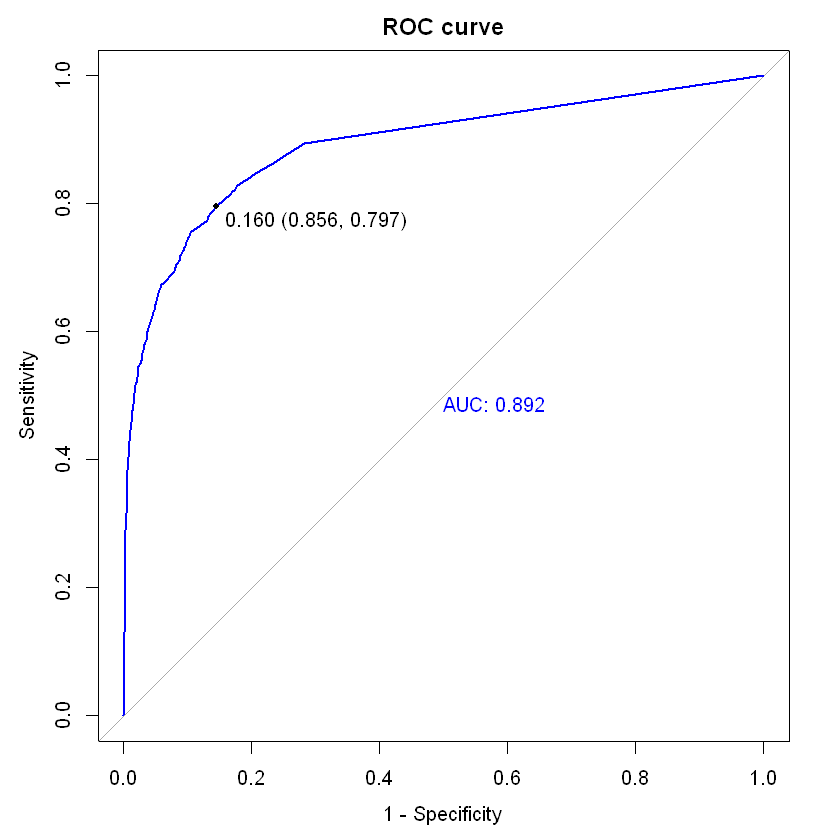

In [62]:
# ROC
kknn_roc_curve <- roc(repay_fail_test, kknn_prob,
                      levels = c("0", "1"), direction = "<")
plot.roc(kknn_roc_curve, main = "ROC curve", col = "blue", lwd = 2,
         legacy.axes = TRUE, print.thres = "best", print.auc = TRUE)

# Calculo el punto de corte óptimo basado en la suma
# de sensibilidades y especificidades
aux <- kknn_roc_curve$sensitivities + kknn_roc_curve$specificities
corte <- kknn_roc_curve$thresholds[which(aux == max(aux))]

# Convierto las probabilidades a clases binarias usando el punto de corte óptimo
kknn_prob <- ifelse(kknn_prob < corte, 0, 1)
kknn_prob <- factor(kknn_prob, levels = c(0, 1),
                    labels = c("0", "1"))

# Resultados
results <- confusionMatrix(kknn_prob, repay_fail_test)
results$table
sensitivity(kknn_prob, repay_fail_test) +
  specificity(kknn_prob, repay_fail_test)

Interpretación de los Resultados
Matriz de Confusión:

- True Negatives (TN): 8371 (Clientes predichos correctamente como que no fallarán en el pago del préstamo).
- False Positives (FP): 1411 (Clientes predichos incorrectamente como que fallarán en el pago del préstamo, pero en realidad no fallarán).
- False Negatives (FN): 350 (Clientes predichos incorrectamente como que no fallarán en el pago del préstamo, pero en realidad sí fallarán).
- True Positives (TP): 1372 (Clientes predichos correctamente como que fallarán en el pago del préstamo).

Curva ROC y AUC:

- La curva ROC muestra la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos (1 - especificidad).
- El área bajo la curva (AUC) es 0.892, lo que indica una buena capacidad del modelo para distinguir entre clientes que fallarán y no fallarán en el pago del préstamo.

- La sensibilidad (True Positive Rate) es la proporción de verdaderos positivos correctamente identificados por el modelo.
- La especificidad (True Negative Rate) es la proporción de verdaderos negativos correctamente identificados por el modelo.

Suma de Sensibilidad y Especificidad:

- La suma de sensibilidad y especificidad es 1.65, lo que refleja un buen equilibrio entre ambos aspectos en el punto de corte óptimo.

In [63]:
# Elimino objetos
rm(kknn_level, kknn_prob, level_prob, results, kknn_roc_curve, aux, corte)

2da forma: Paquete kknn que permite configuracion de parametros k, distancia y kernel, para esta version se buscarán los mejores 3 parametros (k, distancia y kernel), para estos efectos se utilizará el remuestreo k-fold CV y grilla.

2.1 Evaluacion del modelo, mediante metrica de accuracy, teniendo como output un vector de niveles

El objetivo de la siguiente celda de código es encontrar los mejores hiperparámetros para el modelo k-NN utilizando el paquete kknn en R. Se realiza una búsqueda exhaustiva de los hiperparámetros óptimos (k, distancia y kernel) utilizando el remuestreo k-fold cross-validation y una grilla de hiperparámetros. Finalmente, se evalúa el modelo utilizando la métrica de precisión (accuracy).

In [64]:
# Estrategia
cv <- trainControl(method = "cv", number = 2)

# Parámetros
hyper_grid <- expand.grid(kmax = seq(5, 35, 2), distance = seq(1, 3, 1),
                          kernel = "optimal")

Configuración de la Estrategia de Remuestreo:

Se define una estrategia de remuestreo utilizando k-fold cross-validation con 2 folds.

Se crea una grilla de hiperparámetros con diferentes valores para kmax, distance y kernel.

k-Nearest Neighbors 

26841 samples
   12 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 13421, 13420 
Resampling results across tuning parameters:

  kmax  distance  Accuracy   Kappa    
   5    1         0.9053314  0.6021425
   5    2         0.8974703  0.5705626
   5    3         0.8966507  0.5652583
   7    1         0.9086845  0.6084157
   7    2         0.9007862  0.5760751
   7    3         0.8995195  0.5683451
   9    1         0.9096904  0.6087484
   9    2         0.9037667  0.5834413
   9    3         0.9025372  0.5761324
  11    1         0.9115160  0.6106203
  11    2         0.9060021  0.5857015
  11    3         0.9052197  0.5803612
  13    1         0.9124847  0.6114094
  13    2         0.9074923  0.5880011
  13    3         0.9070080  0.5845428
  15    1         0.9125964  0.6102182
  15    2         0.9086473  0.5904283
  15    3         0.9072688  0.5843149
  17    1         0.9128200  0.6090507
 

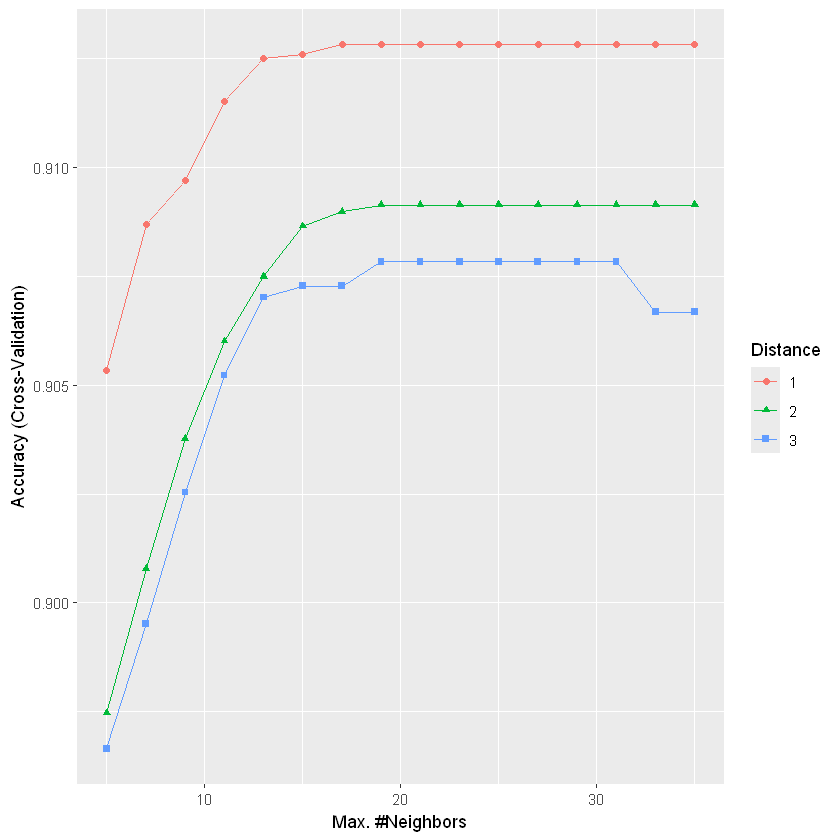

In [65]:
# Configuración del procesamiento en paralelo
# Detecta el número de núcleos disponibles
num_cores <- detectCores()
# Crear cluster
# Usar todos menos uno para no sobrecargar el sistema
cl <- makeCluster(num_cores - 1)
# Registrar el cluster
registerDoParallel(cl)

# Entrenamiento
# tomó 39 minutos
set.seed(12345)
kknn_fit <- train(repay_fail ~ ., data = loan_data_knn_train, method = "kknn",
                  metric = "Accuracy", trControl = cv, tuneGrid = hyper_grid)
kknn_fit
ggplot(kknn_fit)

# Detener el cluster
stopCluster(cl)
registerDoSEQ() # Registramos la secuencia por defecto

Interpretación de los Resultados

Gráfico de Resultados:

El gráfico muestra la precisión (accuracy) obtenida para diferentes combinaciones de hiperparámetros (k, distancia y kernel).

Hiperparámetros Óptimos:

Aunque el modelo seleccionó kmax = 25, distancia = 1 y kernel = "optimal", se observó que la precisión fue la misma para kmax = 17 y kmax = 25. Por lo tanto, se seleccionó kmax = 17 para mayor simplicidad y eficiencia computacional.

Relevancia en el Contexto del Algoritmo k-NN

La búsqueda exhaustiva de los hiperparámetros óptimos es crucial para mejorar el rendimiento del modelo k-NN. Utilizar técnicas de remuestreo como k-fold cross-validation asegura que el modelo se evalúe de manera robusta y generalice bien a datos nuevos.

En el proyecto se está utilizando el k-NN para predecir si un cliente fallará en el pago de su préstamo (repay_fail). La optimización de los hiperparámetros (k, distancia y kernel) mediante una búsqueda en grilla y k-fold cross-validation permite mejorar la precisión del modelo, asegurando que las predicciones sean más confiables.

- Eficiencia Computacional: Seleccionar un valor de k más pequeño cuando la precisión es la misma puede reducir el tiempo de cómputo y la complejidad del modelo sin sacrificar precisión.

- Remuestreo: Usar k-fold cross-validation proporciona una evaluación más fiable del rendimiento del modelo al reducir la varianza que podría resultar de una sola división del conjunto de datos.

En la siguiente celda se evalua el rendimiento del modelo k-NN utilizando los mejores hiperparámetros (k = 17, distance = 1, kernel = "optimal") que se identificaron mediante la búsqueda en grilla y k-fold cross-validation. La métrica utilizada para esta evaluación es la precisión (accuracy)

In [ ]:
# Best Model - Accuracy
set.seed(12345)
kknn_acc <- kknn(repay_fail ~ ., loan_data_knn_train,
                 loan_data_knn_test[, colnames(loan_data_knn_test) !=
                                      "repay_fail"],
                 k = 17, distance = 1, kernel = "optimal")
kknn_acc <- kknn_acc$fitted.values

In [ ]:
## Resultados
results <- confusionMatrix(kknn_acc, repay_fail_test)
results$table
results$overall[names(results$overall) == "Accuracy"]

Interpretación de los Resultados

Matriz de Confusión:

- True Negatives (TN): 9571 (Clientes predichos correctamente como que no fallarán en el pago del préstamo).
- False Positives (FP): 211 (Clientes predichos incorrectamente como que fallarán en el pago del préstamo, pero en realidad no fallarán).
- False Negatives (FN): 704 (Clientes predichos incorrectamente como que no fallarán en el pago del préstamo, pero en realidad sí fallarán).
- True Positives (TP): 1018 (Clientes predichos correctamente como que fallarán en el pago del préstamo).

Precisión (Accuracy):

La precisión del modelo es aproximadamente 92.05%, lo que indica que el modelo clasifica correctamente el 92.05% de las observaciones en el conjunto de prueba.

- True Negatives (TN) y True Positives (TP) son cruciales para identificar correctamente a los clientes que no representan un riesgo y aquellos que sí lo representan, respectivamente.
- False Positives (FP) y False Negatives (FN) deben minimizarse para evitar la pérdida de buenos clientes y no subestimar el riesgo de clientes problemáticos.

2.2 Evaluacion del modelo mediante ROC, teniendo como output un vector de probabilidades

El siguiente código configura una estrategia para evaluar el rendimiento del modelo k-NN utilizando la curva ROC, teniendo como output un vector de probabilidades. Se define una estrategia de remuestreo k-fold cross-validation y se crea una grilla de hiperparámetros para encontrar la mejor combinación de k, distancia y kernel.

In [ ]:
# Estrategia
cv <- trainControl(method = "cv", number = 2, classProbs = TRUE,
                   summaryFunction = twoClassSummary)

# Parámetros
hyper_grid <- expand.grid(kmax = seq(5, 25, 4), distance = seq(1, 3, 1),
                          kernel = c("triangular", "gaussian", "rank",
                                     "optimal"))

Lo que hace el siguiente código es entrenar y evaluar un modelo k-NN utilizando k-fold cross-validation con una grilla de hiperparámetros para optimizar el ROC. La evaluación se realiza utilizando el área bajo la curva ROC (AUC), que mide la capacidad del modelo para distinguir entre clases. Además, se busca identificar los mejores hiperparámetros (k, distancia y kernel).

In [ ]:
# Configuración del procesamiento en paralelo
# Detecta el número de núcleos disponibles
num_cores <- detectCores()
# Crear cluster
# Usar todos menos uno para no sobrecargar el sistema
cl <- makeCluster(num_cores - 1)
# Registrar el cluster
registerDoParallel(cl)

# Me aseguro de que los niveles de 'repay_fail' sean nombres válidos
loan_data_knn_train$repay_fail <- factor(loan_data_knn_train$repay_fail,
                                         levels = c("0", "1"),
                                         labels = c("Class_0", "Class_1"))
loan_data_knn_test$repay_fail <- factor(loan_data_knn_test$repay_fail,
                                        levels = c("0", "1"),
                                        labels = c("Class_0", "Class_1"))
# Entrenamiento
# tomó 52 minutos
set.seed(12345)
kknn_fit <- train(repay_fail ~ ., data = loan_data_knn_train, method = "kknn",
                  metric = "ROC", trControl = cv, tuneGrid = hyper_grid)
kknn_fit
ggplot(kknn_fit)

# Detener el cluster
stopCluster(cl)
registerDoSEQ() # Registramos la secuencia por defecto

Interpretación de los Resultados
Evaluación de Hiperparámetros:

- kmax = 17 y kmax = 25: Los valores de kmax de 17 y 25 muestran un rendimiento similar en términos de AUC, por lo que se seleccionó k = 17 para mayor simplicidad y eficiencia computacional.
- Distance = 1: La distancia óptima identificada es 1.
- Kernel = "optimal": El kernel óptimo es "optimal".

Métricas de Rendimiento:

- ROC: La métrica ROC fue utilizada para seleccionar el modelo óptimo. Un ROC más alto indica una mejor capacidad del modelo para distinguir entre las clases.

- Sensibilidad y Especificidad:

- La sensibilidad (True Positive Rate) es la proporción de verdaderos positivos correctamente identificados por el modelo.
- La especificidad (True Negative Rate) es la proporción de verdaderos negativos correctamente identificados por el modelo.

El proposito del siguiente código es evaluar el rendimiento del modelo k-NN utilizando la curva ROC, teniendo como output un vector de probabilidades y determinando el punto de corte óptimo basado en la suma de sensibilidades y especificidades.

In [ ]:
### Splitting inicial de los datos
set.seed(123) # Semilla
# Muestreo Estratificado
split <- initial_split(loan_data_knn, prop = 0.7, strata = "repay_fail")
loan_data_knn_train <- training(split)
loan_data_knn_test <- testing(split)

# Vectores variable objetivo
repay_fail_train <- loan_data_knn_train$repay_fail
repay_fail_test  <- loan_data_knn_test$repay_fail

In [ ]:
# Best Model - ROC
set.seed(12345)
kknn_roc <- kknn(repay_fail ~ ., loan_data_knn_train,
                 loan_data_knn_test[, colnames(loan_data_knn_test) !=
                                      "repay_fail"],
                 k = 25, distance = 1, kernel = "triangular")
kknn_roc <- kknn_roc$prob
kknn_roc <- as.numeric(kknn_roc[, colnames(kknn_roc) == "1"])

In [ ]:
# ROC
kknn_roc_curve <- roc(repay_fail_test, kknn_roc,
                      levels = c("0", "1"), direction = "<")
plot.roc(kknn_roc_curve, main = "ROC curve", col = "blue", lwd = 2,
         legacy.axes = TRUE, print.thres = "best", print.auc = TRUE)

# Calculo el punto de corte óptimo basado en la
# suma de sensibilidades y especificidades
aux <- kknn_roc_curve$sensitivities + kknn_roc_curve$specificities
corte <- kknn_roc_curve$thresholds[which(aux == max(aux))]

# Convierto las probabilidades a clases binarias usando el punto de corte óptimo
kknn_roc <- ifelse(kknn_roc < corte, 0, 1)
kknn_roc <- factor(kknn_roc, levels = c(0, 1), labels = c("0", "1"))

Curva ROC (Imagen)

- La curva ROC muestra la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos (1 - especificidad).
- El área bajo la curva (AUC) es 0.909, lo que indica una buena capacidad del modelo para distinguir entre clientes que fallarán y no fallarán en el pago del préstamo.

Interpretación de los Resultados

Curva ROC y AUC:

- Área Bajo la Curva (AUC): Un AUC de 0.909 indica una excelente capacidad del modelo para distinguir entre clientes que fallarán y no fallarán en el pago del préstamo. Un AUC cercano a 1 indica un modelo muy eficaz.
- Curva ROC: La curva ROC proporciona una visión gráfica de la trade-off entre la sensibilidad (tasa de verdaderos positivos) y la especificidad (tasa de verdaderos negativos). Un punto en la curva más cercano a la esquina superior izquierda indica un mejor rendimiento del modelo.
- Umbral de Decisión: El punto en la curva con coordenadas (0.153, 0.833, 0.843) indica el umbral de probabilidad óptimo de 0.153, con una sensibilidad de 0.833 y una especificidad de 0.843.

In [ ]:
# Asegurarse de que repay_fail_test sea un factor con los niveles correctos
repay_fail_test <- factor(repay_fail_test, levels = c(0, 1))

# Resultados
results <- confusionMatrix(kknn_roc, repay_fail_test)
results$table
sensitivity(kknn_roc, repay_fail_test) + specificity(kknn_roc, repay_fail_test)

Interpretación de los Resultados

Matriz de Confusión:

- True Negatives (TN): 8150 (Clientes predichos correctamente como que no fallarán en el pago del préstamo).
- False Positives (FP): 1632 (Clientes predichos incorrectamente como que fallarán en el pago del préstamo, pero en realidad no fallarán).
- False Negatives (FN): 271 (Clientes predichos incorrectamente como que no fallarán en el pago del préstamo, pero en realidad sí fallarán).
- True Positives (TP): 1451 (Clientes predichos correctamente como que fallarán en el pago del préstamo).

Sensibilidad y Especificidad:

- Sensibilidad (True Positive Rate): Es la proporción de verdaderos positivos correctamente identificados por el modelo. En este caso, 1451 clientes que realmente fallaron en pagar el préstamo fueron correctamente identificados.
- Especificidad (True Negative Rate): Es la proporción de verdaderos negativos correctamente identificados por el modelo. En este caso, 8150 clientes que realmente no fallaron en pagar el préstamo fueron correctamente identificados.

Suma de Sensibilidad y Especificidad:

La suma de sensibilidad y especificidad es 1.6758, lo que refleja un buen equilibrio entre ambos aspectos en el punto de corte óptimo.

Comparación de Resultados y Conclusiones

1. Precisión (Accuracy):

- Primera Configuración: La precisión del modelo es 90.78%.
- Segunda Configuración: La precisión del modelo es 92.05%.

Conclusión: La optimización de los hiperparámetros mediante remuestreo y grilla resultó en una mejora en la precisión del modelo.

2. Matriz de Confusión:

Primera Configuración:

- True Negatives (TN): 9395
- False Positives (FP): 387
- False Negatives (FN): 674
- True Positives (TP): 1048

Segunda Configuración:

- True Negatives (TN): 9571
- False Positives (FP): 211
- False Negatives (FN): 704
- True Positives (TP): 1018

Conclusión: La segunda configuración reduce significativamente el número de falsos positivos (FP) y ligeramente los verdaderos positivos (TP), lo que mejora la precisión general del modelo.

3. Evaluación mediante ROC:

Primera Configuración:
- AUC: 0.892
- Mejor Umbral de Corte: 0.160
- Suma de Sensibilidad + Especificidad: 1.65250343670887

Segunda Configuración:
- AUC: 0.909
- Umbral de Corte: 0.153
- Suma de Sensibilidad + Especificidad: 1.67578780718146

Conclusión: La segunda configuración también mejora el AUC, lo que indica una mejor capacidad del modelo para distinguir entre clientes que fallarán y no fallarán en el pago de sus préstamos. La mejora en la suma de sensibilidad y especificidad también refleja un mejor balance entre estos dos aspectos críticos.

4. Sensibilidad y Especificidad:

- Primera Configuración: Sensibilidad y especificidad combinadas dan un valor de 1.65250343670887.
- Segunda Configuración: Sensibilidad y especificidad combinadas dan un valor de 1.67578780718146.

Conclusión: La segunda configuración proporciona un equilibrio ligeramente mejor entre la sensibilidad y la especificidad, lo cual es crucial en el contexto del problema para identificar correctamente tanto a los clientes que no fallarán como a los que sí fallarán.

Conclusiones Finales

- La optimización de los hiperparámetros utilizando remuestreo k-fold cross-validation y una grilla de parámetros ha demostrado ser más efectiva que el uso de parámetros subóptimos configurados manualmente. - Los resultados indican mejoras en la precisión (accuracy), el AUC, y la suma de sensibilidad y especificidad. En el contexto del problema de predecir si los clientes fallarán en el pago de sus préstamos, estas mejoras significan una mayor capacidad del modelo para identificar correctamente tanto a los clientes que representen un riesgo como a aquellos que no.